# **Setting up the Environment**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## **Data Import**

In [4]:
from google.colab import files
files.upload()

Saving NF-BoT-IoT.csv to NF-BoT-IoT.csv


In [5]:
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col
df="/content/NF-BoT-IoT.csv"
RANDOM_SEED = 141109
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 8
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32
#load dataset
df1 = spark.read.options(header="true",inferschema = "true").csv(df)

## **Data Exploration and Pre-processing**

In [ ]:
print(f"The shape is {df1.count():d} rows by {len(df1.columns):d} columns.")

The shape is 600100 rows by 14 columns.


In [ ]:
null_counts = df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c)for c in df1.columns]).toPandas().to_dict(orient='records')
print(f"We have {sum(null_counts[0].values()):d} null values in this dataset.")

We have 0 null values in this dataset.


In [ ]:
df1.dtypes

[('IPV4_SRC_ADDR', 'string'),
 ('L4_SRC_PORT', 'int'),
 ('IPV4_DST_ADDR', 'string'),
 ('L4_DST_PORT', 'int'),
 ('PROTOCOL', 'int'),
 ('L7_PROTO', 'double'),
 ('IN_BYTES', 'int'),
 ('OUT_BYTES', 'int'),
 ('IN_PKTS', 'int'),
 ('OUT_PKTS', 'int'),
 ('TCP_FLAGS', 'int'),
 ('FLOW_DURATION_MILLISECONDS', 'int'),
 ('Label', 'int'),
 ('Attack', 'string')]

In [ ]:
df1.head(10)

[Row(IPV4_SRC_ADDR='192.168.100.6', L4_SRC_PORT=52670, IPV4_DST_ADDR='192.168.100.1', L4_DST_PORT=53, PROTOCOL=17, L7_PROTO=5.212000000000001, IN_BYTES=71, OUT_BYTES=126, IN_PKTS=1, OUT_PKTS=1, TCP_FLAGS=0, FLOW_DURATION_MILLISECONDS=4294966, Label=0, Attack='Benign'),
 Row(IPV4_SRC_ADDR='192.168.100.6', L4_SRC_PORT=49160, IPV4_DST_ADDR='192.168.100.149', L4_DST_PORT=4444, PROTOCOL=6, L7_PROTO=0.0, IN_BYTES=217753000, OUT_BYTES=199100, IN_PKTS=4521, OUT_PKTS=4049, TCP_FLAGS=24, FLOW_DURATION_MILLISECONDS=4176249, Label=1, Attack='Theft'),
 Row(IPV4_SRC_ADDR='192.168.100.46', L4_SRC_PORT=3456, IPV4_DST_ADDR='192.168.100.5', L4_DST_PORT=80, PROTOCOL=17, L7_PROTO=0.0, IN_BYTES=8508021, OUT_BYTES=8918372, IN_PKTS=9086, OUT_PKTS=9086, TCP_FLAGS=0, FLOW_DURATION_MILLISECONDS=4175916, Label=0, Attack='Benign'),
 Row(IPV4_SRC_ADDR='192.168.100.3', L4_SRC_PORT=80, IPV4_DST_ADDR='192.168.100.55', L4_DST_PORT=8080, PROTOCOL=6, L7_PROTO=7.0, IN_BYTES=8442138, OUT_BYTES=9013406, IN_PKTS=9086, OUT_P

In [ ]:
df1.select('label').distinct().rdd.map(lambda r: r[0]).collect()

[1, 0]

In [6]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
df1.columns

['IPV4_SRC_ADDR',
 'L4_SRC_PORT',
 'IPV4_DST_ADDR',
 'L4_DST_PORT',
 'PROTOCOL',
 'L7_PROTO',
 'IN_BYTES',
 'OUT_BYTES',
 'IN_PKTS',
 'OUT_PKTS',
 'TCP_FLAGS',
 'FLOW_DURATION_MILLISECONDS',
 'Label',
 'Attack']

In [ ]:
df1.printSchema()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- Label: integer (nullable = true)
 |-- Attack: string (nullable = true)



In [ ]:
pdf = df1.toPandas()

## **Data Visualization**

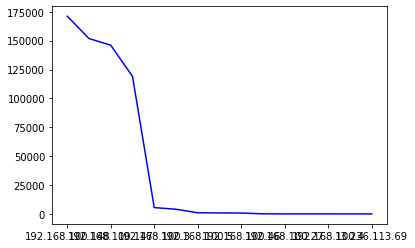

In [ ]:
pdf['IPV4_SRC_ADDR'].value_counts().plot.line(color="blue")

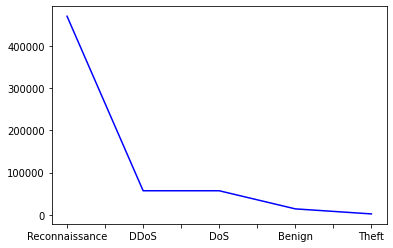

In [ ]:
pdf['Attack'].value_counts().plot.line(color="blue")

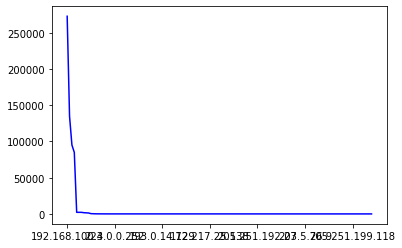

In [ ]:
pdf['IPV4_DST_ADDR'].value_counts().plot.line(color="blue")

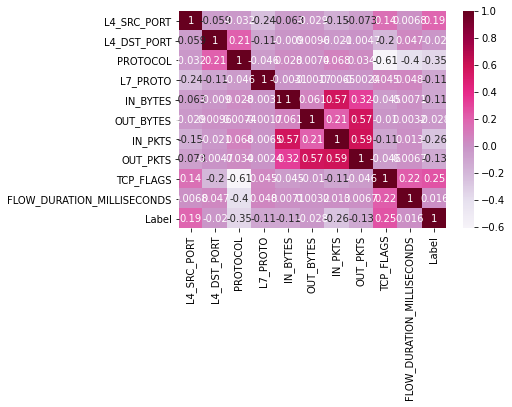

In [ ]:
sns.heatmap(pdf.corr(),cmap='PuRd',annot=True)

In [ ]:
df1.describe().toPandas().transpose()

0                   1  ...        3              4
summary                      count                mean  ...      min            max
IPV4_SRC_ADDR               600100                None  ...  0.0.0.0  192.168.100.7
L4_SRC_PORT                 600100   46528.90197967005  ...        0          65535
IPV4_DST_ADDR               600100                None  ...  0.0.0.0     96.7.49.66
L4_DST_PORT                 600100   7949.493862689552  ...        0          65535
PROTOCOL                    600100   6.584854190968172  ...        1             17
L7_PROTO                    600100   8.956317862022987  ...      0.0          244.0
IN_BYTES                    600100   9222.367618730212  ...       28      228223480
OUT_BYTES                   600100   6997.821951341443  ...        0      243219688
IN_PKTS                     600100  12.433891018163639  ...        1          37817
OUT_PKTS                    600100   5.696410598233628  ...        0          61110
TCP_FLAGS                   600100  21.856518913514414  ...        0            214
FLOW_DURATION_MILLISECONDS  600100  3468594.3355107484  ...        0        4294967
Label                       600100  0.9769055157473754  ...        0              1
Attack                      600100                None  ...   Benign          Theft

[15 rows x 5 columns]

In [7]:
featurecolumn=['L4_SRC_PORT','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','OUT_BYTES','IN_PKTS','OUT_PKTS','TCP_FLAGS','FLOW_DURATION_MILLISECONDS']

In [8]:
df1 = VectorAssembler(inputCols=featurecolumn, outputCol="features").transform(df1)

In [9]:
df1.select("label", "features").show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[52670.0,53.0,17....|
|    1|[49160.0,4444.0,6...|
|    0|[3456.0,80.0,17.0...|
|    0|[80.0,8080.0,6.0,...|
|    0|[80.0,80.0,6.0,7....|
+-----+--------------------+
only showing top 5 rows



In [10]:
# Generate a labelIndexer
labelIndexer = StringIndexer(inputCol="Label", outputCol="indexedLabel").fit(df1)

# Generate the indexed feature vector
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df1)
    
# Split the data into training and tests sets
(trainingData, testData) = df1.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])


rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and the forest models in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [39]:
y_test = testData.select("Label")

In [ ]:
x_val=trainingData.select("Label")
x_val.toPandas()

In [ ]:
output = pd.DataFrame(index=None, columns=['model','Accuracy'])

In [68]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# **Linear** **Regression** 

In [74]:
import time
#LinearRegression
from pyspark.ml.regression import LinearRegression
regressor = LinearRegression(featuresCol = 'features', labelCol = 'Label')
#Learn to fit the model from training set
start_time=time.time()
regressor = regressor.fit(trainingData)
end_time=time.time()
print("Training Time:",end_time-start_time)
#To predict on testing set
start_time=time.time()
pred = regressor.evaluate(testData)
end_time=time.time()
print("Testing Time:",end_time-start_time)
#Predict the model
pred.predictions.show()

Training Time: 13.678279161453247
Testing Time: 8.396796226501465
+---------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+--------------+--------------------+------------------+
|  IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|OUT_BYTES|IN_PKTS|OUT_PKTS|TCP_FLAGS|FLOW_DURATION_MILLISECONDS|Label|        Attack|            features|        prediction|
+---------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+--------------+--------------------+------------------+
|192.168.100.147|          0|192.168.100.3|          0|       1|     0.0|      40|        0|      1|       0|        0|                         0|    1|Reconnaissance|(10,[2,4,6],[1.0,...|1.0715234504346924|
|192.168.100.147|          0|192.168.100.3|          0|       1|     0.0|      80|        0|      2|  

In [75]:
#coefficient of the regression model
coeff = regressor.coefficients
#X and Y intercept
intr = regressor.intercept
print ("The coefficient of the model is : %a" %coeff)
print ("The Intercept of the model is : %f" %intr)

The coefficient of the model is : DenseVector([0.0, 0.0, -0.0235, -0.0004, 0.0, 0.0, -0.0002, 0.0, 0.0003, -0.0])
The Intercept of the model is : 1.095143


In [ ]:
evaluator2 = MulticlassClassificationEvaluator(
  labelCol="Label", predictionCol="prediction", metricName="accuracy")
predictions = regressor.transform(testData)

accuracy = evaluator2.evaluate(predictions)
print(f"Test Error = {(1.0 - accuracy):g}")

print(f"Accuracy = {accuracy*100:g}")
s2=accuracy*100
output = output.append(pd.Series({'model':'Linear Regression', 'Test error':1-accuracy,'Accuracy':accuracy*100}),ignore_index=True )
output

Test Error = 0.224758
Accuracy = 77.5242


model   Accuracy  Test error
0  Linear Regression  77.524194    0.224758

In [31]:
y_pred=pred.predictions
y_pred.show(5)

+---------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+--------------+--------------------+------------------+
|  IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|OUT_BYTES|IN_PKTS|OUT_PKTS|TCP_FLAGS|FLOW_DURATION_MILLISECONDS|Label|        Attack|            features|        prediction|
+---------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+--------------+--------------------+------------------+
|192.168.100.147|          0|192.168.100.3|          0|       1|     0.0|      40|        0|      1|       0|        0|                         0|    1|Reconnaissance|(10,[2,4,6],[1.0,...|1.0715234504346924|
|192.168.100.147|          0|192.168.100.3|          0|       1|     0.0|      80|        0|      2|       0|        0|                    900779|    1|Reconnaissance|(

### **Different** **Evaluation** **Metrics**

In [77]:
from sklearn import metrics
y_test_pred_lr = pred.predictions.select("prediction")
y_test_pred_lr = y_test_pred_lr.toPandas()
#Variance Regression Score
print("Variance Regression Score:",metrics.explained_variance_score(y_test,y_test_pred_lr))
#Max_Error_Metric
print("Max Error Metric:",metrics.max_error(y_test,y_test_pred_lr))
#Mean Absolute Error
print("Mean Absolute Error:",metrics.mean_absolute_error(y_test,y_test_pred_lr))
#Mean Squared Error
print("Mean Squared Error:",metrics.mean_squared_error(y_test,y_test_pred_lr))
#Median Absolute Error
print("Median Absolute Error:",metrics.median_absolute_error(y_test,y_test_pred_lr))
print("r2-score:",metrics.r2_score(y_test, y_test_pred_lr))

Variance Regression Score: 0.22521000984698603
Max Error Metric: 3.789995219884723
Mean Absolute Error: 0.049107483710262016
Mean Squared Error: 0.01708599570730223
Median Absolute Error: 0.021089354631103507
r2-score: 0.22520044144225826


# **Naive** **Bayes**

In [71]:
#NaiveBayes
from pyspark.ml.classification import NaiveBayes

# Train a NaiveBayes model
nb = NaiveBayes(labelCol="indexedLabel", featuresCol="indexedFeatures",smoothing=1.0)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb])

# Run stages in pipeline and train model
start_time=time.time()
model = pipeline.fit(trainingData)
end_time=time.time()
print("Training Time:",end_time-start_time)
# Predicting results
start_time=time.time()
predictions = model.transform(testData)
end_time=time.time()
print("Testing Time:",end_time-start_time)
predictions.select("features","Label","prediction" ).show(5)

Training Time: 5.1913042068481445
Testing Time: 0.14880847930908203
+--------------------+-----+----------+
|            features|Label|prediction|
+--------------------+-----+----------+
|(10,[2,4,6],[1.0,...|    1|       1.0|
|(10,[2,4,6,9],[1....|    1|       0.0|
|(10,[2,4,6],[1.0,...|    1|       1.0|
|(10,[2,4,6,9],[1....|    1|       0.0|
|(10,[2,4,6],[1.0,...|    1|       1.0|
+--------------------+-----+----------+
only showing top 5 rows



In [ ]:
evaluator4 = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator4.evaluate(predictions)
print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy*100:g}")
s3=accuracy*100
output = output.append(pd.Series({'model':'Naive Bayes', 'Test error':1-accuracy,'Accuracy':accuracy*100}),ignore_index=True )
output

Test Error = 0.0226185
Accuracy = 97.7382


model   Accuracy  Test error
0  LinearRegression  77.524194    0.224758
1       Naive Bayes  97.738152    0.022618

### **Classification** **Report**

In [72]:
y_pred_nb = predictions.select("prediction")
y_pred_nb=y_pred_nb.toPandas()
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.02      0.89      0.04      4059
           1       0.51      0.00      0.01    175852

    accuracy                           0.02    179911
   macro avg       0.26      0.45      0.02    179911
weighted avg       0.50      0.02      0.01    179911



# **Decision** **Tree**

In [58]:
#DecisionTree
from pyspark.ml.classification import DecisionTreeClassifier
labelIndexer = StringIndexer(inputCol="Label", outputCol="indexedLabel").fit(df1)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df1)
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",maxDepth=5,impurity='gini',minInstancesPerNode=20)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer,dt])


In [59]:
start_time=time.time()
model = pipeline.fit(trainingData)
end_time=time.time()
print("Training Time:",end_time-start_time)
start_time=time.time()
predictions = model.transform(testData)
end_time=time.time()
print("Testing Time:",end_time-start_time)
predictions.select("features","Label","prediction" ).show(5)

Training Time: 14.594330310821533
Testing Time: 0.10471701622009277
+--------------------+-----+----------+
|            features|Label|prediction|
+--------------------+-----+----------+
|(10,[2,4,6],[1.0,...|    1|       0.0|
|(10,[2,4,6,9],[1....|    1|       0.0|
|(10,[2,4,6],[1.0,...|    1|       0.0|
|(10,[2,4,6,9],[1....|    1|       0.0|
|(10,[2,4,6],[1.0,...|    1|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



In [ ]:
evaluator1 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy1 = evaluator1.evaluate(predictions)
TestError=1.0-accuracy1
print(f"Test Error = {(1.0 - accuracy1):g}")
print(f"Accuracy = {accuracy1:g}")
s4=accuracy1*100
output = output.append(pd.Series({'model':'Decision Tree', 'Test error':TestError,'Accuracy':accuracy1*100}),ignore_index=True )
output

Test Error = 0.0120839
Accuracy = 0.987916


model   Accuracy  Test error
0  LinearRegression  77.524194    0.224758
1       Naive Bayes  97.738152    0.022618
2     Decision Tree  98.791608    0.012084

### **Classification** **Report**

In [62]:
y_pred_dt =predictions.select("prediction")
y_pred_dt=y_pred_dt.toPandas()
print(metrics.classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.01      0.47      0.02      4059
           1       0.07      0.00      0.00    175852

    accuracy                           0.01    179911
   macro avg       0.04      0.23      0.01    179911
weighted avg       0.07      0.01      0.00    179911



# **Graphical** **Representation**

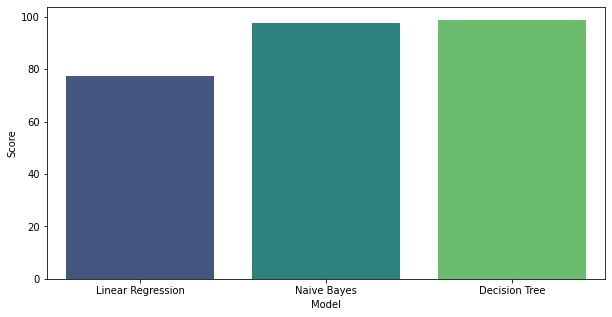

In [ ]:
#Graphical Representation
models = pd.DataFrame({'Model':['Linear Regression','Naive Bayes','Decision Tree'],'Score':[s2,s3,s4]})
models.sort_values(by='Score',ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=models['Model'],y=models['Score'],palette='viridis')